# Isochrone Research and Path Plotting

So I did a bunch of research this weekend about isochrones and geographic data - will try to write up what I've done so far. 

## Isochrones

Isochrone generation is something Santerre mentioned as potential area of interest in our modelling approach. The idea is that given a starting location, we can produce a series of radii representing how far the bear can travel in some distance or time measurement. In an urban environment, an isochrone map looks something like this. 

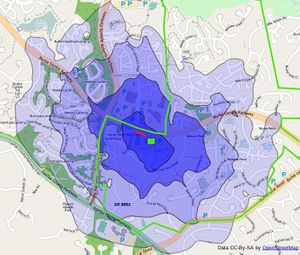

[source](https://wiki.openstreetmap.org/wiki/File:SRTS_walkability_after_new_sidewalk.jpg)

Here the green dot is the starting point. The first black contour line represents 1/4 mile walking distance, the second 1/2 mile walking, etc. It's pretty cool since we see that in reality, an isochrone map will never be a perfect circle. The allowed paths will differ in certain directions - in the above example, walking northeast is much more difficult than walking south. Applied to our bears, we can "restrict" paths in certain directions. 

### Issues

These maps are typically generated with GIS data, in urban environments. From what I can find online, all pre-build isochrone generators focus on urban environments. This makes sense, as urban environments do have discrete travel paths (roads, sidewalks) and can collect traversal time data. If Google Maps sees that 1000 drivers take 30 minutes on average to travel 5 miles on I-5, you can build a traversal tree pretty easily with that information. 

Unfortunately with us, we do not have much GIS experience and we are not modelling an urban environment. I set out with a goal to generate an isochrone map for one of our bears, but none of the pre-built packages suit our area of interest - rural Louisiana. This means if we want to be serious about including this, we will have to implement our own isochrone generator from scratch. 

I'm not sure how to do this honestly. We do not have much GIS experience, and I don't think Python is the right tool for modelling complex geographies. This could be a question for Santerre. Fundamentally, this is a graph traversal problem which is within our skillset. But I think determining the nodes and transitions will be very difficult. 

## Paths

One thing that might be useful still and actually achievable is looking at the actual paths our bears are taking. Where are they walking, and what patterns can we notice?

I'm using animations to visualize this - since we have two coordinates (lat/long) and a time dimension. This is more of an EDA exercise than a production for our paper. But it might still be useful to visualize. 

One extension (will see if I can come up with some ideas) is to look for "hotspots" - areas in our coordinate system that our bears tend to cluster around, for longer periods of time. 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

Note about the code: I was unable to import matplotlib version 3.3.1 (newest, default from conda install) - I had to pin it to 3.2.2 in my conda environment. I can't tell if this is a unique issue to my machine or not, but try that if you get some **ImportError: Cannot import 'dedent' from matplotlib.cbook**

In [146]:
bears = pd.read_csv('allbear9att_update.txt', delimiter='\t')

In [129]:
# Set a datetime index. This doesn't actually help at all for the plotting, 
# but in my head a multi-index on bear_id and GPS time makes the most sense in the long term.
bears.GPS_Fix_Time = pd.to_datetime(bears.GPS_Fix_Time)
bears = bears.set_index('GPS_Fix_Time')

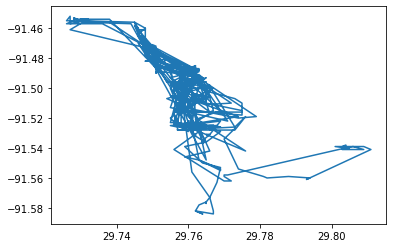

In [130]:
# case study. Plot the path
bear2 = bears.loc[bears.Bear_ID==2]
plt.plot(bear2.Latitude, bear2.Longitude)

This is somewhat useful, but doesn't really give a good sense of order. Where does the bear spend time, what order is governing its movement? 

Need to animate for that. 

In [126]:
def plot_path(data, bear_id):
    
    """
    Returns an animated plot of a given bear's movement. 
    
    data: the full dataset, with lat long coordinates
    bear_id: specify a single bear to model, otherwise these plots get way way too complex. 
    
    """
    # Subset
    bear = data.loc[data.Bear_ID == bear_id].reset_index()
    
    # invert data for plotting. Shape is (2, n)
    data = np.array([bear.Latitude, bear.Longitude])
    
    # Set limits
    epsilon = .01
    xlims = (min(data[0]) - epsilon, max(data[0]) + epsilon)
    ylims = (min(data[1]) - epsilon, max(data[1]) + epsilon)

    fig1 = plt.figure()
    plt.xlim(xlims)
    plt.ylim(ylims)
    l, = plt.plot([], [], 'r-')
    
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title(f'Path for bear {bear_id}')

    def update_line(num, data, line):
        line.set_data(data[..., (max(0, num-8)):num])
        return line,

    rc('animation', html='html5')
    anim = animation.FuncAnimation(fig1, update_line, data.shape[1], fargs=(data, l),
                                       interval=100, blit=True)
    return anim

In [134]:
%%capture # done to prevent the static plot from plt.plot([], []) appearing
anim = plot_path(bears, 2.0)

In [135]:
%matplotlib inline
anim

We see some eye-test evidence of the levy flight behavior Santerre mentioned. The bear travels large distances quickly to explore the lower-right and top-left quadrants a bit, before migrating back to the center. Looking at another arbitrary bear: 

In [136]:
%%capture
bear5_anim = plot_path(bears, 5.0)

In [137]:
%matplotlib inline
bear5_anim

We see again somewhat similar evidence. There are definitely long stretches of quick movement, followed by almost circular exploratory pattern. 

Let's look at a heatmap of the whole region. The hope here is that we see clusters of hotspots - either bears are congregating somewhere or individuals are spending a lot of time in one spot. 

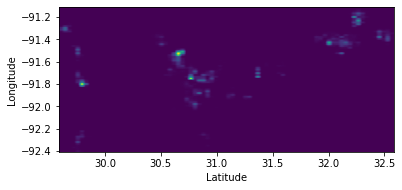

In [145]:
# Entire region heatmap
heatmap, xedges, yedges = np.histogram2d(bears.Latitude, bears.Longitude, bins=80)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

Not the most informative plot, but we do see some bright-green clusters near the left-middle, upper-middle, and upper-right areas of our coordinate grid. 